In [22]:
import time

# import setGPU
import numpy
import h5py
import pandas as pd
import pennylane as qml
import scipy as sp
from matplotlib import pyplot as plt
# from pickle import load
from json import load
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score
from pennylane import numpy as np

In [23]:
events = numpy.load('10k_dijet.npy')
scaler = MinMaxScaler(feature_range=(0, sp.pi))
events = scaler.fit_transform(events)

events_bkg = numpy.load('10k_dijet_bb1.npy')
classes = numpy.load('10k_dijet_bb1_class.npy')
events_bkg = scaler.fit_transform(events_bkg)

In [24]:
f = open('events_LHCO2020_BlackBox1.masterkey', 'r')
event_classes = numpy.genfromtxt(f, delimiter=',')
print(event_classes.shape)
event_class = event_classes[classes.tolist()]

(1000000,)


In [25]:
def make_ansatz_qml(ansatz_saved):
    ansatz_qml = []
    params = []
    for j in range(len(ansatz_saved)):
        moment_dict = {i: list() for i in ['I', 'RX', 'RY', 'RZ', 'CNOT']}
        stored_i = []
        for i in range(3):
            _ix = ansatz_saved[j][f'{i}'].find('_')
            if _ix < 0:
                moment_dict[ansatz_saved[j][f'{i}']].append(i)
            else:
                if i in stored_i:
                    continue
                _1ix = ansatz_saved[j][f'{i}'][_ix+1]
                q_p = int(ansatz_saved[j][f'{i}'][-1])
                stored_i.append(q_p)
                if _1ix == 'C':
                    moment_dict[ansatz_saved[j][f'{i}'][:_ix]].append([i, int(q_p)])
                else:
                    moment_dict[ansatz_saved[j][f'{i}'][:_ix]].append([int(q_p), i])

        for k in moment_dict.keys():
            if len(moment_dict[k]) == 0 or k == 'I': # add in identity gates?
                continue
            if len(k) <= 2:
                ansatz_qml.append(f"qml.broadcast(qml.{k}, wires={moment_dict[k]}, pattern='single', parameters=params[{len(params)}:{len(params)+len(moment_dict[k])}])")
                # change to allow for one-qubit gates with 0 or 2+ params
                for i in range(len(moment_dict[k])):
                    params.append(0.0)
            elif len(k) > 2: # Assumes the 2-qubit gates have no parameters, which is not generally true
                ansatz_qml.append(f"qml.broadcast(qml.{k}, wires={np.array(moment_dict[k]).flatten(order='C').tolist()}, pattern={moment_dict[k]})")
                # change to allow for two-qubit gates with 1+ params

    return ansatz_qml, params

In [26]:
with open('/Users/tsievert/GA Caltech/GA_Ansatz_Search/ga_vqc/ga_runs/final_evolution_results-2023-03-24_15-47-24.json', "r") as f:
    final_dict = load(f)

ansatz_saved = final_dict['best_ansatz']
print(ansatz_saved)
    
ansatz_qml, parameters = make_ansatz_qml(ansatz_saved)
# ansatz_qml = numpy.load('qae_runs_2022-11-16_10-23-03/opt_ansatz/31_002ga_best1e+03_run_ansatz.npy')
print(ansatz_qml)
# parameters = np.load('qae_runs_2022-11-16_10-23-03/opt_thetas/31_002ga_best1e+03_data_theta.npy')
print(parameters)
print(len(parameters))

[{'0': 'RZ', '1': 'RX', '2': 'RX'}, {'0': 'RZ', '1': 'RX', '2': 'RX'}, {'0': 'RY', '1': 'CNOT_C-2', '2': 'CNOT_T-1'}, {'0': 'RZ', '1': 'I', '2': 'RX'}]
["qml.broadcast(qml.RX, wires=[1, 2], pattern='single', parameters=params[0:2])", "qml.broadcast(qml.RZ, wires=[0], pattern='single', parameters=params[2:3])", "qml.broadcast(qml.RX, wires=[1, 2], pattern='single', parameters=params[3:5])", "qml.broadcast(qml.RZ, wires=[0], pattern='single', parameters=params[5:6])", "qml.broadcast(qml.RY, wires=[0], pattern='single', parameters=params[6:7])", 'qml.broadcast(qml.CNOT, wires=[1, 2], pattern=[[1, 2]])', "qml.broadcast(qml.RX, wires=[2], pattern='single', parameters=params[7:8])", "qml.broadcast(qml.RZ, wires=[0], pattern='single', parameters=params[8:9])"]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
9


In [27]:
n_shots = 5000
# dev1 = qml.device('qulacs.simulator', wires=6, gpu=True, shots=n_shots)
dev1 = qml.device('default.qubit', wires=6, shots=n_shots)
@qml.qnode(dev1)
def circuit(params, event=None):
    # Embed the data into the circuit
    qml.broadcast(qml.RX, wires=range(3), pattern='single', parameters=event)
    qml.Hadamard(wires=5)
    # Run the actual circuit ansatz
    for m in ansatz_qml:
        exec(m)

    # Perform the SWAP-Test for a qubit fidelity measurement
    qml.broadcast(qml.CSWAP, wires=range(1, 6), pattern=[[5, 1, 3], [5, 2, 4]])
    qml.Hadamard(wires=5)

    qml.PauliX(wires=5)

    return qml.expval(qml.PauliZ(wires=5))

# def cost_func(params, data):
#     return (circuit(params, event=data)**2)**(1/2)

In [28]:
rng = np.random.default_rng()
qng_cost = [[], [], [], [], []]
opt = qml.QNGOptimizer(1e-7)
ix = 0
start_time = time.time()
# for train_size, steps in zip([10], [200]):
train_size = 1000
steps = 500
best_perf = [100000, np.array([])]
theta = sp.pi * rng.random(size=20, requires_grad=True)
event_sub = rng.choice(events, train_size, replace=False)
for _ in range(steps):

    if train_size > 100:
        event_batch = rng.choice(event_sub, 100, replace=False)
    else:
        event_batch = event_sub

    grads = np.zeros((event_batch.shape[0], theta.shape[0]))
    costs = np.zeros(event_batch.shape[0])

    if (_%25 == 1 or _==(steps-1)):
        print('Step %d with cost %.4f' % (_, qng_cost[ix][-1]))

    for i in range(event_batch.shape[0]):
        fub_stud = qml.metric_tensor(circuit, approx='block-diag')(theta, event=event_batch[i]) # doesnt compute fubiny-study automatically??
        grads[i] = np.matmul(fub_stud, opt.compute_grad(circuit, (theta, event_batch[i]), {})[0][0]) # isn't already anti-gradient??
        costs[i] = circuit(theta, event=event_batch[i])
        # if costs[i].item() < 0: # corrects for non-normality of SWAP test, in order to avoid over-training
        #     grads[i] *= -1
        #     costs[i] *= -1
    if best_perf[0] > costs.mean(axis=0):
        best_perf[0] = costs.mean(axis=0)
        best_perf[1] = theta
    theta = theta - np.sum(grads, axis=0)
    qng_cost[ix].append(costs.mean(axis=0))

np.save('ga_best%.e_data_theta' % train_size, best_perf[1])
plt.figure(train_size)
plt.style.use("seaborn")
plt.plot(qng_cost[ix], "g", label="QNG Descent - %d data" % train_size)
plt.ylabel("Loss (-1 * Fid.)")
plt.xlabel("Optimization steps")
plt.legend()
plt.savefig("GA_QNG_Descent-%d_data.pdf" % train_size)
plt.show()
# ix += 1
    
end_time = time.time()
exec_time = end_time-start_time
print(f'QML Optimization in {exec_time:.2f} seconds')

Step 1 with cost -0.2708
Step 26 with cost -0.3455
Step 51 with cost -0.0769
Step 76 with cost -0.6805
Step 101 with cost -0.5213
Step 126 with cost -0.0479


KeyboardInterrupt: 

In [30]:
opt_params = np.load('/Users/tsievert/GA Caltech/QAE_4_HEP/qae_runs_2023-03-24_15-47-24/opt_thetas/04_009ga_best5e+02_data_theta.npy')

print(opt_params)
print(parameters)

[-0.64649619  8.46673929  1.48231182 -0.28421222  6.61017405  1.48552513
 -0.07996761  9.17665508  0.81777654]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


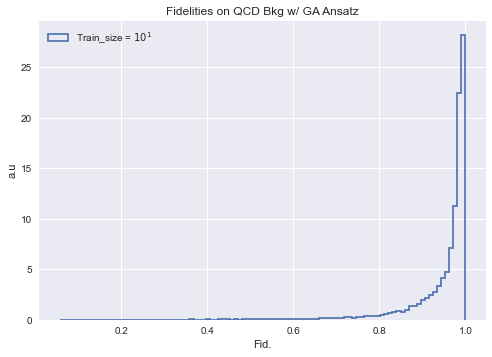

In [31]:
# best_theta = parameters
best_theta = opt_params
fid = [None, None, None, None, None]
for j in range(1):
    cost = []

    for i in range(np.size(events, axis=0)):
        cost.append(circuit(best_theta, event=events[i, :]))

    fid[j] = -1 * np.array(cost)

plt.style.use("seaborn")
plt.xlabel('Fid.')
plt.ylabel('a.u')
plt.title('Fidelities on QCD Bkg w/ GA Ansatz')
for j in range(1):
    plt.hist(fid[j], bins=100, density=True, histtype='step', linewidth=1.7, label='Train_size = $10^{%d}$' % 1)
    
plt.legend(loc='upper left')
plt.savefig("ga_cont_fid_hist.pdf")

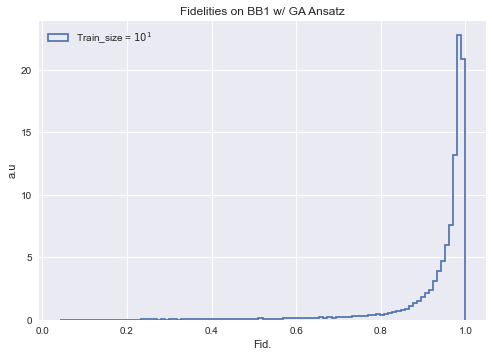

In [32]:
fid_bb1 = [None, None, None, None, None]
for j in range(1):
    cost = []

    for i in range(np.size(events_bkg, axis=0)):
        cost.append(circuit(best_theta, event=events_bkg[i, :]))

    fid_bb1[j] = -1 * np.array(cost)
    
plt.style.use("seaborn")
plt.xlabel('Fid.')
plt.ylabel('a.u')
plt.title('Fidelities on BB1 w/ GA Ansatz')
for j in range(1):
    plt.hist(fid_bb1[j], bins=100, density=True, histtype='step', linewidth=1.7, label='Train_size = $10^{%d}$' % 1)
    
plt.legend(loc='upper left')
plt.savefig("ga_cont_fid_hist_bb1.pdf")

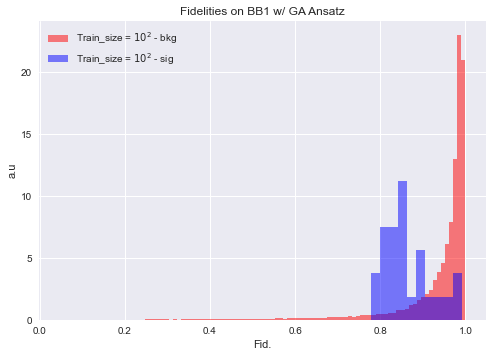

In [33]:
fid_split = [None, None]
bkg_cost, sig_cost = [], []
sig_event_count = 0

for i in range(np.size(events_bkg, axis=0)):
    if event_class[i] == 0:
        bkg_cost.append(circuit(best_theta, event=events_bkg[i, :]))
    elif event_class[i] == 1:
        sig_event_count += 1
        sig_cost.append(circuit(best_theta, event=events_bkg[i, :]))

color_arr = ['r', 'b']
for i in range(2):
    if i == 0:
        label_str = 'bkg'
        fid_split[i] = -1 * np.array(bkg_cost)
        n_bins = 100
    elif i == 1:
        label_str = 'sig'
        fid_split[i] = -1 * np.array(sig_cost)
        n_bins = 10
    
    plt.hist(fid_split[i], bins=n_bins, density=True, color=color_arr[i], alpha=0.5, linewidth=1.7, label='Train_size = $10^{%d}$ - %s' % (2, label_str))
    plt.legend(loc='upper left')
    plt.title('Fidelities on BB1 w/ GA Ansatz')
    plt.style.use("seaborn")
    plt.xlabel('Fid.')
    plt.ylabel('a.u')
    
plt.savefig("ga_cont_fid_hist_bb1_split.pdf")

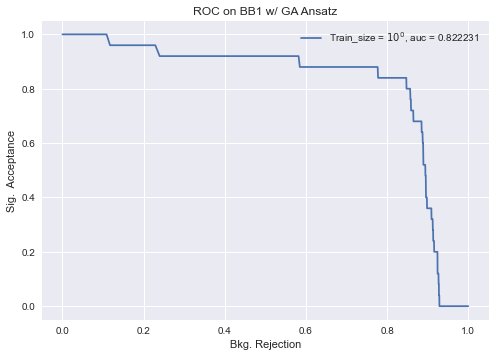

In [34]:
plt.title('ROC on BB1 w/ GA Ansatz')
plt.style.use("seaborn")
plt.xlabel('Bkg. Rejection')
plt.ylabel('Sig.  Acceptance')
k = 0
for y in fid_bb1[:1]:
    y_pred = [1 - i.tolist() for i in y]
    fpr, tpr, thresholds = roc_curve(event_class, y_pred)
    bkg_rejec = 1 - fpr
    
    plt.plot(bkg_rejec, tpr, label='Train_size = $10^{%d}$, auc = %.04f' % (k, roc_auc_score(event_class, y_pred)))
    k += 1

plt.legend()
plt.savefig("ga_roc_bb1.pdf")